In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image, Markdown, display
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [12]:
df = pd.read_csv("../DATA/aus_livestock.csv")
df.ds = pd.to_datetime(df.ds)
df = df[df.unique_id == "Victoria_Pigs"]

In [39]:
model = AutoETS(season_length=12, model="ANN")
model.fit(y=df.y.values)

AutoETS

<Axes: >

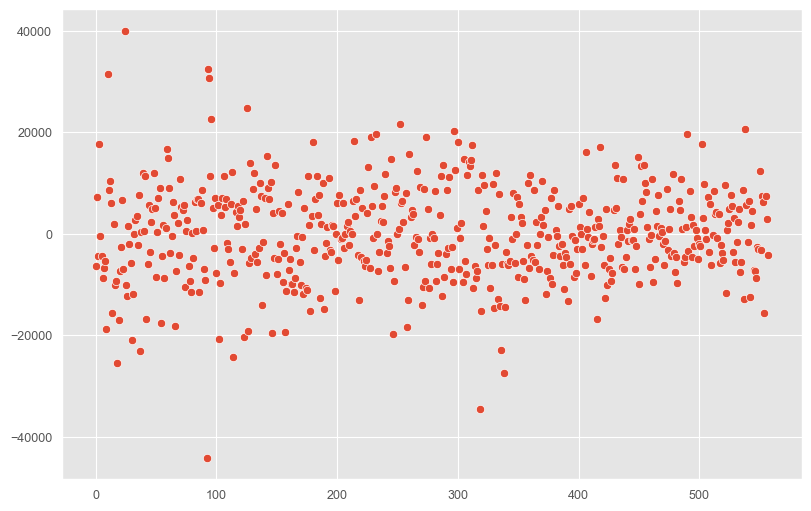

In [43]:
sns.scatterplot(model.model_["actual_residuals"])

In [62]:
resid_std = model.model_["actual_residuals"].std()
confidence_interval = 1.96 * resid_std

<Axes: ylabel='y'>

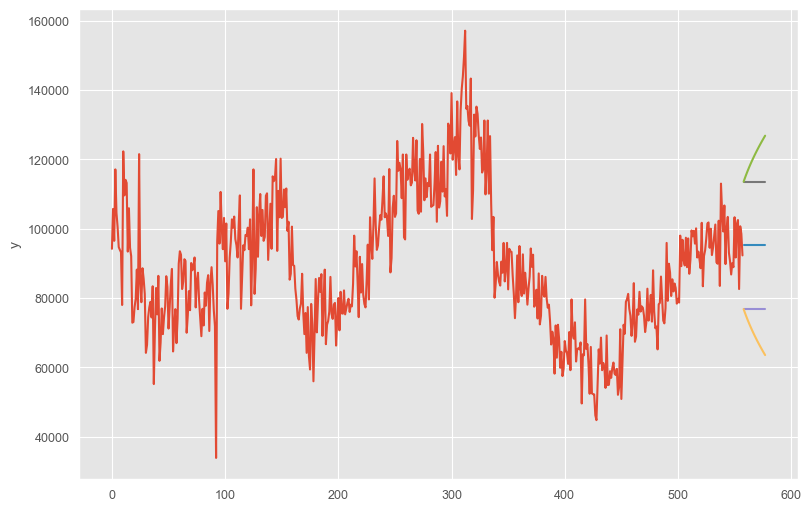

In [69]:
sf = StatsForecast(models=[AutoETS(season_length=12, model="ANN")], freq="M")
fc = sf.forecast(df=df, h=20, level=[80, 95])

sns.lineplot(x=range(len(df.y)), y=df.y)
sns.lineplot(x=range(len(df.y), len(df.y) + 20), y=model.predict(20)["mean"])
sns.lineplot(
    x=range(len(df.y), len(df.y) + 20),
    y=model.predict(20)["mean"] - confidence_interval,
)
sns.lineplot(
    x=range(len(df.y), len(df.y) + 20),
    y=model.predict(20)["mean"] + confidence_interval,
)


sns.lineplot(x=range(len(df.y), len(df.y) + 20), y=fc["AutoETS-lo-95"])
sns.lineplot(x=range(len(df.y), len(df.y) + 20), y=fc["AutoETS-hi-95"])